## <u>Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import calendar

# from
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from datetime import timedelta
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
import itertools

# imports for supplemental Data
!pip install holidays
import holidays
import datetime as dt
from holidays import country_holidays

#import tick customization tools
import matplotlib.ticker as mticks
import matplotlib.dates as mdates

## Setting figures to timeseries-friendly
plt.rcParams['figure.figsize'] = (12,4)
plt.rcParams['figure.facecolor'] = 'white'
sns.set_context("talk", font_scale=0.9)

# set random seed
SEED = 321
np.random.seed(SEED)

#display more columns
pd.set_option('display.max_columns',50)

In [2]:
# function to format y-axis units
def thousands(x, pos):
    """formats count in thousands"""
    new_x = x / 1000
    return f"{new_x:,.0f}K"

In [3]:
# # Set the path to the directory containing  CSV files
# file = 'Data/Chicago-Crime_2022.csv'
# # Use the glob module to get a list of all CSV files in the specified directory
# df = pd.read_csv(file)

### Trying to see if this new method will work for my notebook
f = "Data/Chicago-Crime*.csv"
crime_data = sorted(glob.glob(f))
crime_data

['Data\\Chicago-Crime_2001.csv',
 'Data\\Chicago-Crime_2002.csv',
 'Data\\Chicago-Crime_2003.csv',
 'Data\\Chicago-Crime_2004.csv',
 'Data\\Chicago-Crime_2005.csv',
 'Data\\Chicago-Crime_2006.csv',
 'Data\\Chicago-Crime_2007.csv',
 'Data\\Chicago-Crime_2008.csv',
 'Data\\Chicago-Crime_2009.csv',
 'Data\\Chicago-Crime_2010.csv',
 'Data\\Chicago-Crime_2011.csv',
 'Data\\Chicago-Crime_2012.csv',
 'Data\\Chicago-Crime_2013.csv',
 'Data\\Chicago-Crime_2014.csv',
 'Data\\Chicago-Crime_2015.csv',
 'Data\\Chicago-Crime_2016.csv',
 'Data\\Chicago-Crime_2017.csv',
 'Data\\Chicago-Crime_2018.csv',
 'Data\\Chicago-Crime_2019.csv',
 'Data\\Chicago-Crime_2020.csv',
 'Data\\Chicago-Crime_2021.csv',
 'Data\\Chicago-Crime_2022.csv']

In [4]:
# Reading Dataframe
df = pd.concat([pd.read_csv(f, lineterminator='\n') for f in crime_data])
df

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
0,1326041,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185
1,1319931,01/01/2001 01:00:00 PM,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841
2,1324743,01/01/2001 01:00:00 PM,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970
3,1310717,01/01/2001 01:00:00 AM,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032
4,1318099,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020
...,...,...,...,...,...,...,...,...,...,...,...,...
238853,12938029,12/31/2022 12:50:00 PM,ASSAULT,SIMPLE,APARTMENT,False,False,1014,10.0,24.0,41.855911,-87.719966
238854,12937822,12/31/2022 12:50:00 PM,ASSAULT,AGGRAVATED - HANDGUN,APARTMENT,False,True,733,7.0,6.0,41.766546,-87.645669
238855,12937583,12/31/2022 12:52:00 AM,BATTERY,SIMPLE,BARBERSHOP,False,False,1135,11.0,28.0,41.868829,-87.686098
238856,12938420,12/31/2022 12:52:00 PM,ASSAULT,SIMPLE,COMMERCIAL / BUSINESS OFFICE,False,False,1432,14.0,32.0,41.930693,-87.685657


In [5]:
# Looking over data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7713109 entries, 0 to 238857
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Date                  object 
 2   Primary Type          object 
 3   Description           object 
 4   Location Description  object 
 5   Arrest                bool   
 6   Domestic              bool   
 7   Beat                  int64  
 8   District              float64
 9   Ward                  float64
 10  Latitude              float64
 11  Longitude             float64
dtypes: bool(2), float64(4), int64(2), object(4)
memory usage: 662.0+ MB


In [26]:
# # making a date range that covers full dataset
# all_days = pd.date_range(df_crime["Date"].min(), df_crime["Date"].max())
# all_days

In [6]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %I:%M:%S %p')
df['Date']

0        2001-01-01 01:00:00
1        2001-01-01 13:00:00
2        2001-01-01 13:00:00
3        2001-01-01 01:00:00
4        2001-01-01 01:00:00
                 ...        
238853   2022-12-31 12:50:00
238854   2022-12-31 12:50:00
238855   2022-12-31 00:52:00
238856   2022-12-31 12:52:00
238857   2022-12-31 12:59:00
Name: Date, Length: 7713109, dtype: datetime64[ns]

In [7]:
# Setting the Index
df = df.set_index('Date')
df

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
Date,,,,,,,,,,,
2001-01-01 01:00:00,1326041,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185
2001-01-01 13:00:00,1319931,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841
2001-01-01 13:00:00,1324743,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970
2001-01-01 01:00:00,1310717,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032
2001-01-01 01:00:00,1318099,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 12:50:00,12938029,ASSAULT,SIMPLE,APARTMENT,False,False,1014,10.0,24.0,41.855911,-87.719966
2022-12-31 12:50:00,12937822,ASSAULT,AGGRAVATED - HANDGUN,APARTMENT,False,True,733,7.0,6.0,41.766546,-87.645669
2022-12-31 00:52:00,12937583,BATTERY,SIMPLE,BARBERSHOP,False,False,1135,11.0,28.0,41.868829,-87.686098


In [8]:
# to many hiccups creating a copy
df_crime = df.copy()
df_crime

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
Date,,,,,,,,,,,
2001-01-01 01:00:00,1326041,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185
2001-01-01 13:00:00,1319931,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841
2001-01-01 13:00:00,1324743,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970
2001-01-01 01:00:00,1310717,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032
2001-01-01 01:00:00,1318099,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 12:50:00,12938029,ASSAULT,SIMPLE,APARTMENT,False,False,1014,10.0,24.0,41.855911,-87.719966
2022-12-31 12:50:00,12937822,ASSAULT,AGGRAVATED - HANDGUN,APARTMENT,False,True,733,7.0,6.0,41.766546,-87.645669
2022-12-31 00:52:00,12937583,BATTERY,SIMPLE,BARBERSHOP,False,False,1135,11.0,28.0,41.868829,-87.686098


In [9]:
# Resampling
df_crime = df_crime.resample("D").sum()
df_crime

C:\Users\Valde\AppData\Local\Temp\ipykernel_12556\431049365.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_crime = df_crime.resample("D").sum()


,ID,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
Date,,,,,,,,
2001-01-01,4011740634,400,378,2267987,21147.0,8194.0,72641.077994,-152199.715024
2001-01-02,1545846568,383,187,1404493,12797.0,147.0,47664.670569,-99856.853277
2001-01-03,1542074517,343,197,1462886,13359.0,132.0,48045.805839,-100651.350927
2001-01-04,1555657957,377,179,1397040,12994.0,0.0,48785.523718,-102222.916683
2001-01-05,1701884634,415,200,1530155,14044.0,156.0,52769.463977,-110554.590960
...,...,...,...,...,...,...,...,...
2022-12-27,7543189950,70,96,694723,6812.0,14192.0,21427.078656,-44887.568351
2022-12-28,7983384637,63,112,697152,6830.0,14030.0,22592.581721,-47339.899182
2022-12-29,8358666625,66,107,718511,7037.0,14292.0,23639.979313,-49528.016672


## <u>Topic 1) Comparing Police Districts</u>
* Which district had the most crimes in 2022?
* Which had the least?

In [10]:
# my value counts for df_crime would not work decided to try a different route
# since I had so many issues
df_crime_district = df.loc['2022'].groupby("District").count()['Primary Type']

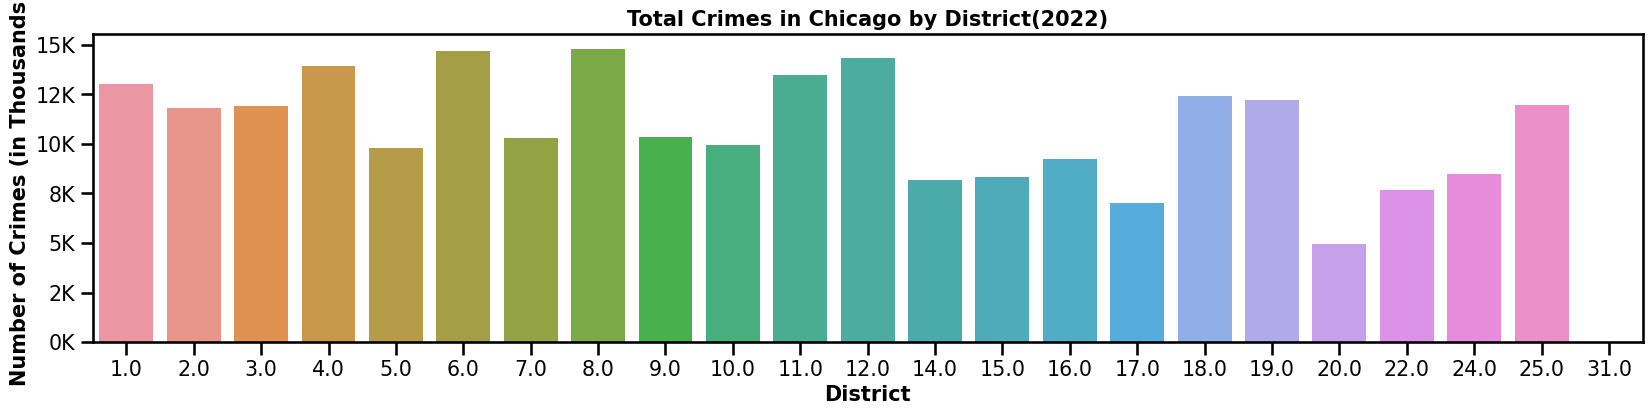

In [11]:
# decided to place in a plot my simple list wont work
district_crimes = df_crime_district.value_counts()

fig, ax = plt.subplots(figsize = (20, 4))
ax = sns.barplot(x = df_crime_district.index, y = df_crime_district.values)


fmt_thous = mticks.FuncFormatter(thousands)
ax.yaxis.set_major_formatter(fmt_thous)

ax.set_title('Total Crimes in Chicago by District(2022)', fontsize = 15, weight = 'bold')
ax.set_ylabel('Number of Crimes (in Thousands)', fontsize = 15, weight = 'bold')
ax.set_xlabel('District', fontsize = 15, weight = 'bold');

### `The highest amount of crimes was in district 8 the lowest was in district 31.`

## <u>Topic 2) Crimes Across the Years:</u>
* Is the total number of crimes increasing or decreasing across the years?

In [12]:
# #df = df_crime.resample("A").size()
# df_annual  = df_crime.groupby("Year").size()
# df_annual.head()
## Not sure why the above code wouldn't work tried this method instead
df_years = df.resample('Y').size()

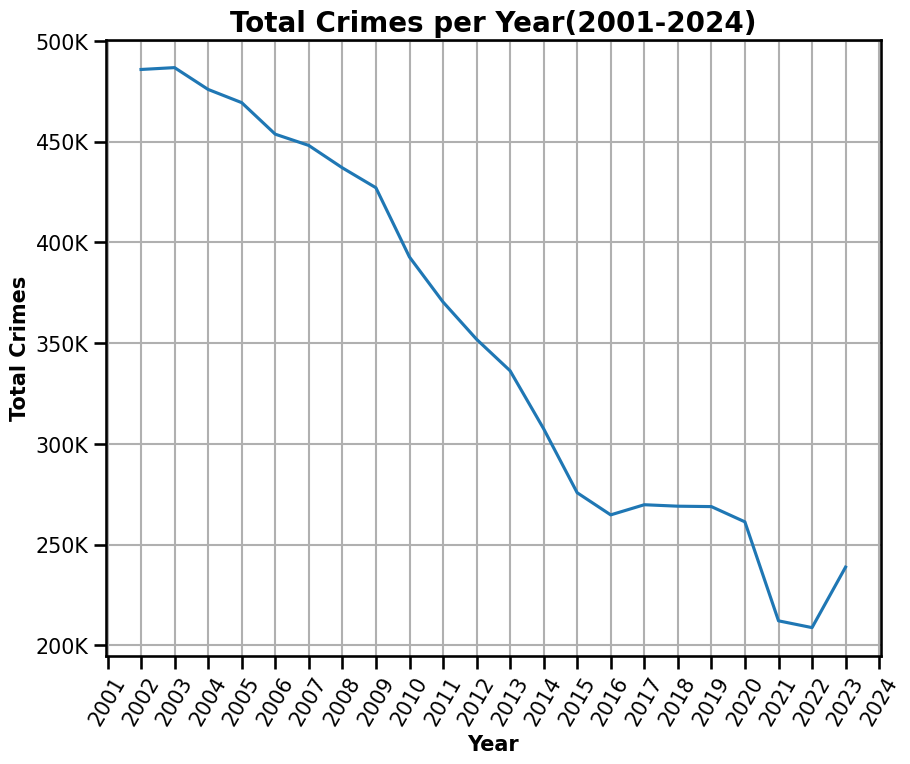

In [13]:
fig, ax = plt.subplots(figsize = (10, 8))
ax = sns.lineplot(x = df_years.index, y = df_years.values)

fmt_thous = mticks.FuncFormatter(thousands)
ax.yaxis.set_major_formatter(fmt_thous)

major_ticks_loc = mdates.YearLocator(1)
major_ticks_format = mdates.DateFormatter('%Y')
x_years = pd.date_range(start = '2001', end = '2024', freq = 'AS')
plt.xticks(x_years, [year.year for year in x_years])

plt.xticks(rotation = 60)
ax.grid()

ax.set_title('Total Crimes per Year(2001-2024)', fontsize = 20, weight = 'bold')
ax.set_ylabel('Total Crimes', fontsize = 15, weight = 'bold')
ax.set_xlabel('Year', fontsize = 15, weight = 'bold');

### The total number of crimes have been decreasing over time the main downfall looked like during the Covid period

In [14]:
# Looking at the individual crimes
indiv_crimes = df.groupby('Primary Type').resample("Y").size()
indiv_crimes

Primary Type       Date      
ARSON              2001-12-31    1011
                   2002-12-31    1032
                   2003-12-31     955
                   2004-12-31     778
                   2005-12-31     691
                                 ... 
WEAPONS VIOLATION  2018-12-31    5456
                   2019-12-31    6339
                   2020-12-31    8432
                   2021-12-31    8980
                   2022-12-31    8766
Length: 723, dtype: int64

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

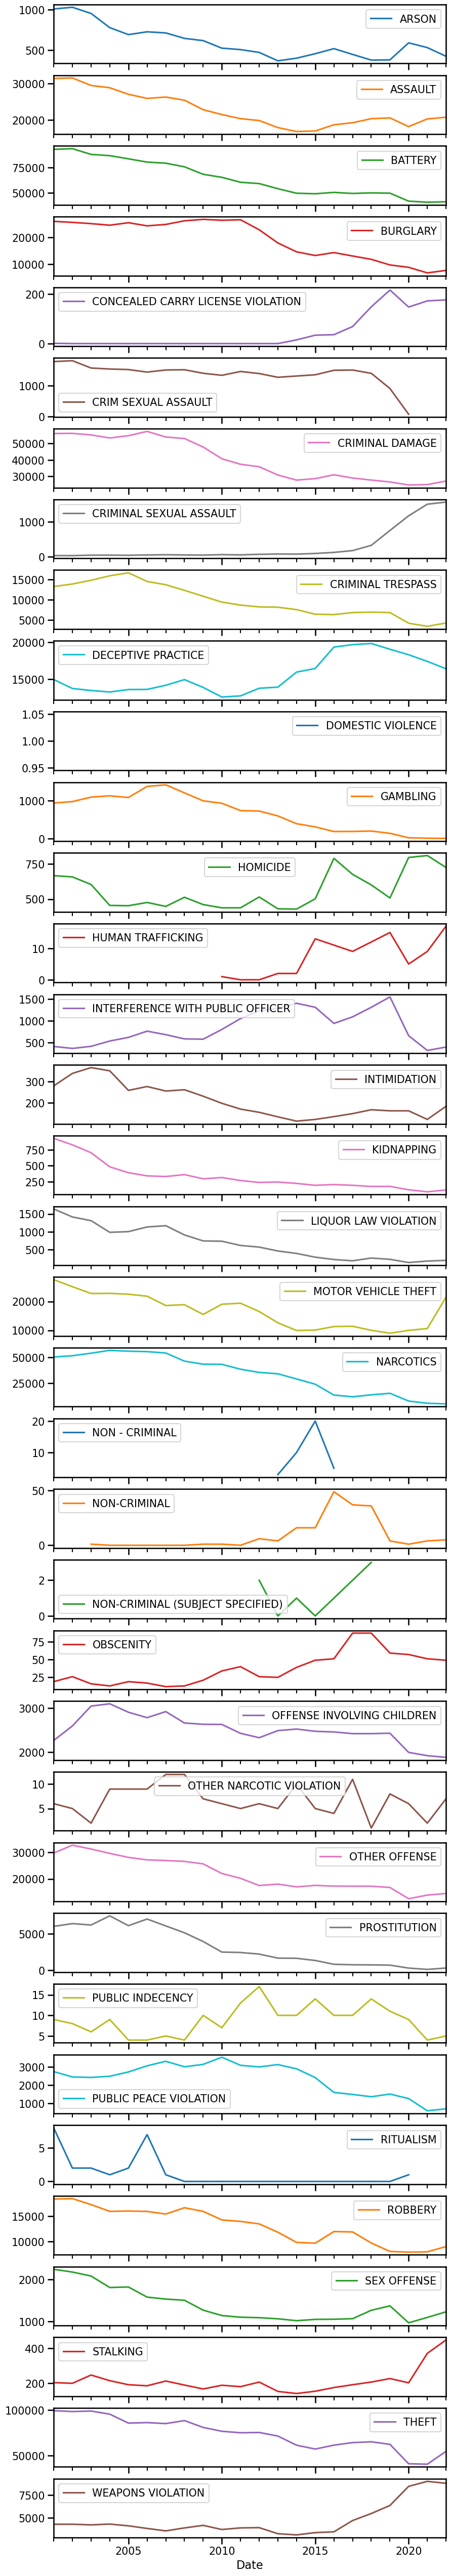

In [15]:
# Taking a closer by unstacking the individual crimes
indiv_crimes.unstack().T.plot(subplots=True, figsize = (10,65))

### A few crimes are increasing and they are :
* Concealed Carry License Violation
* Criminal Sexual Assault
* Deceptive Practice
* Homicide
* Human Trafficking
* Obscenity
* Stalking
* Weapons Violation
### However I did notice that domestic violence is low however I believe it would be hight because so many people don't report.

## <u>Topic 3)Comparing AM vs PM Rush Hour:</u>
* Are crimes more common during the AM rush hour or PM rush hour?
    * You can consider any crime that occurred between 7 AM - 10 am as AM rush hour.
    * You can consider any crime that occured between 4 - 7 PM as PM rush hour.
* `Answer the questions:` What are the top 5  most common crimes during AM rush hour? What are the top 5 most common crimes during PM rush hour?
* `Answer the questions:` Are Motor Vehicle Thefts more common during AM rush hour or PM rsuh hour?

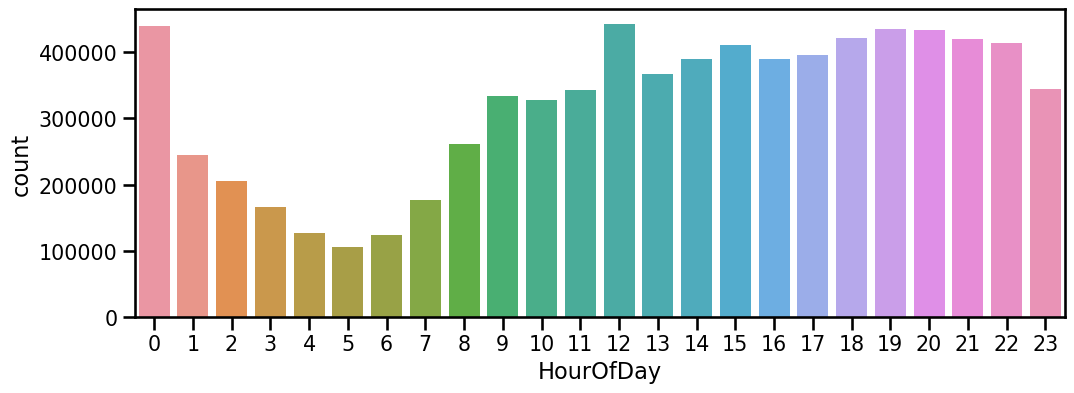

In [16]:
df['HourOfDay'] = df.index.hour
sns.countplot(data=df, x='HourOfDay');

## Crimes are more common in the PM Rush

### `What are the top 5 most common crimes during AM rush hour? What are the top 5 most common crimes during PM rush hour?`

In [17]:
crimes_by_hour = df.groupby("HourOfDay")['Primary Type'].value_counts(normalize=False)
crimes_by_hour

HourOfDay  Primary Type                    
0          THEFT                               91882
           BATTERY                             71777
           CRIMINAL DAMAGE                     64386
           DECEPTIVE PRACTICE                  40410
           OTHER OFFENSE                       27799
                                               ...  
23         PUBLIC INDECENCY                        6
           NON-CRIMINAL                            4
           RITUALISM                               3
           HUMAN TRAFFICKING                       1
           NON-CRIMINAL (SUBJECT SPECIFIED)        1
Name: Primary Type, Length: 800, dtype: int64

In [18]:
am_rush = crimes_by_hour.loc[7]+crimes_by_hour.loc[8]+crimes_by_hour.loc[9]+crimes_by_hour.loc[10]
am_rush

Primary Type
ARSON                                  1139
ASSAULT                               73636
BATTERY                              158475
BURGLARY                              96219
CONCEALED CARRY LICENSE VIOLATION       157
CRIM SEXUAL ASSAULT                    2567
CRIMINAL DAMAGE                      109089
CRIMINAL SEXUAL ASSAULT                 544
CRIMINAL TRESPASS                     30493
DECEPTIVE PRACTICE                    80006
GAMBLING                                652
HOMICIDE                               1133
HUMAN TRAFFICKING                        19
INTERFERENCE WITH PUBLIC OFFICER       1380
INTIMIDATION                            907
KIDNAPPING                             1649
LIQUOR LAW VIOLATION                    409
MOTOR VEHICLE THEFT                   54035
NARCOTICS                             67032
NON - CRIMINAL                           19
NON-CRIMINAL                             40
OBSCENITY                               145
OFFENSE INVOLVING C

In [19]:
pm_rush = crimes_by_hour.loc[16]+crimes_by_hour.loc[17]+crimes_by_hour.loc[18]+crimes_by_hour.loc[19]
pm_rush

Primary Type
ARSON                                  1523.0
ASSAULT                              118179.0
BATTERY                              288003.0
BURGLARY                              78604.0
CONCEALED CARRY LICENSE VIOLATION       187.0
CRIM SEXUAL ASSAULT                    3874.0
CRIMINAL DAMAGE                      183423.0
CRIMINAL SEXUAL ASSAULT                 824.0
CRIMINAL TRESPASS                     48564.0
DECEPTIVE PRACTICE                    58973.0
GAMBLING                               4905.0
HOMICIDE                               2227.0
HUMAN TRAFFICKING                        12.0
INTERFERENCE WITH PUBLIC OFFICER       4403.0
INTIMIDATION                           1008.0
KIDNAPPING                             2092.0
LIQUOR LAW VIOLATION                   4168.0
MOTOR VEHICLE THEFT                   74678.0
NARCOTICS                            164754.0
NON - CRIMINAL                            5.0
NON-CRIMINAL                             40.0
NON-CRIMINAL (SUBJECT

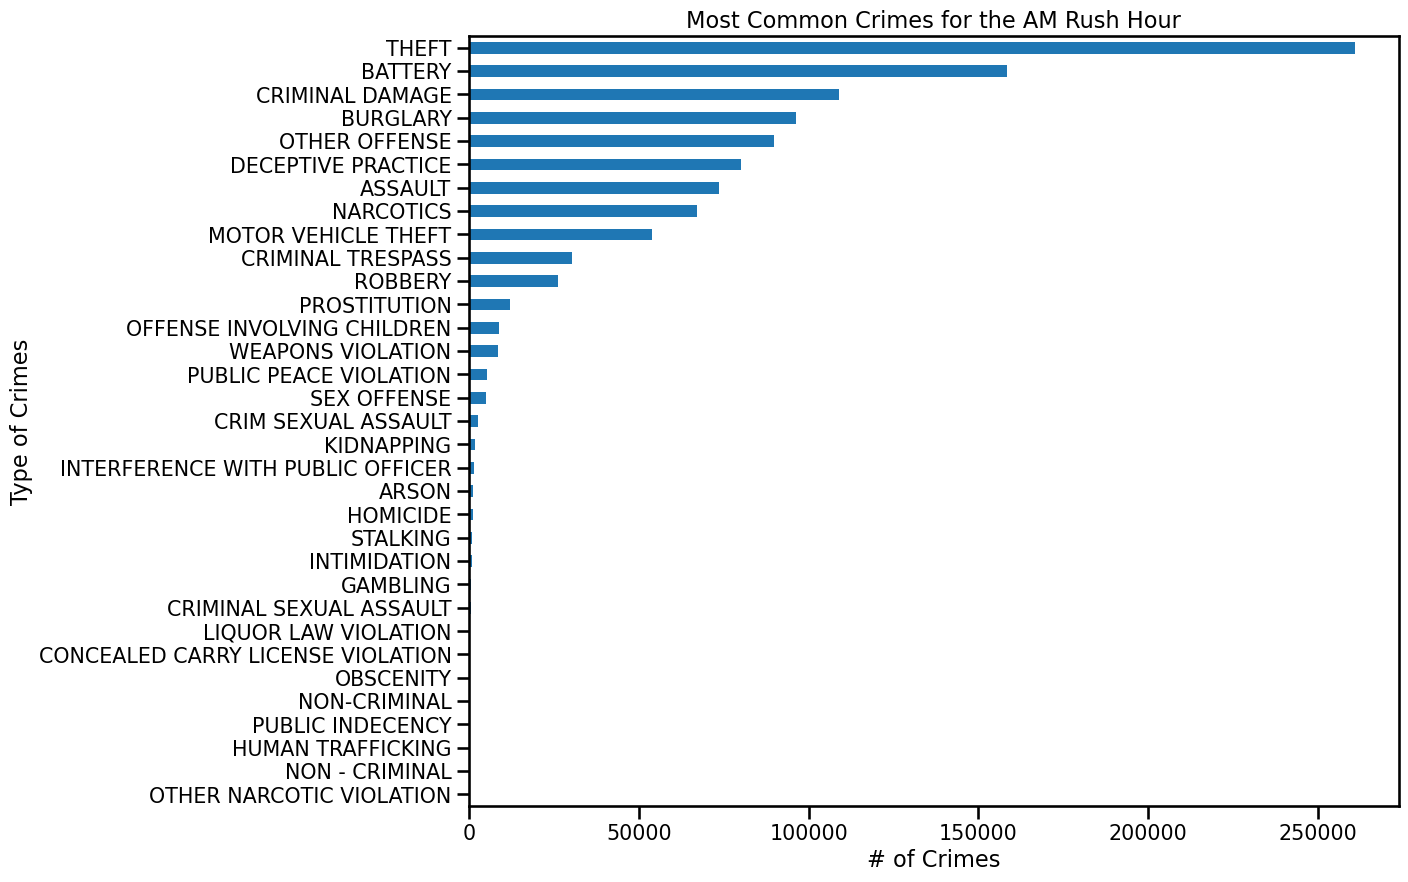

In [38]:
ax = am_rush.sort_values().plot(kind='barh',figsize=(12,10))
ax.set(title='Most Common Crimes for the AM Rush Hour',xlabel='# of Crimes',ylabel='Type of Crimes');

### `The Top 5 most common crimes in the AM Rush are:`
* Theft
* Battery
* Criminal Damage
* Burglary
* Criminal Damage

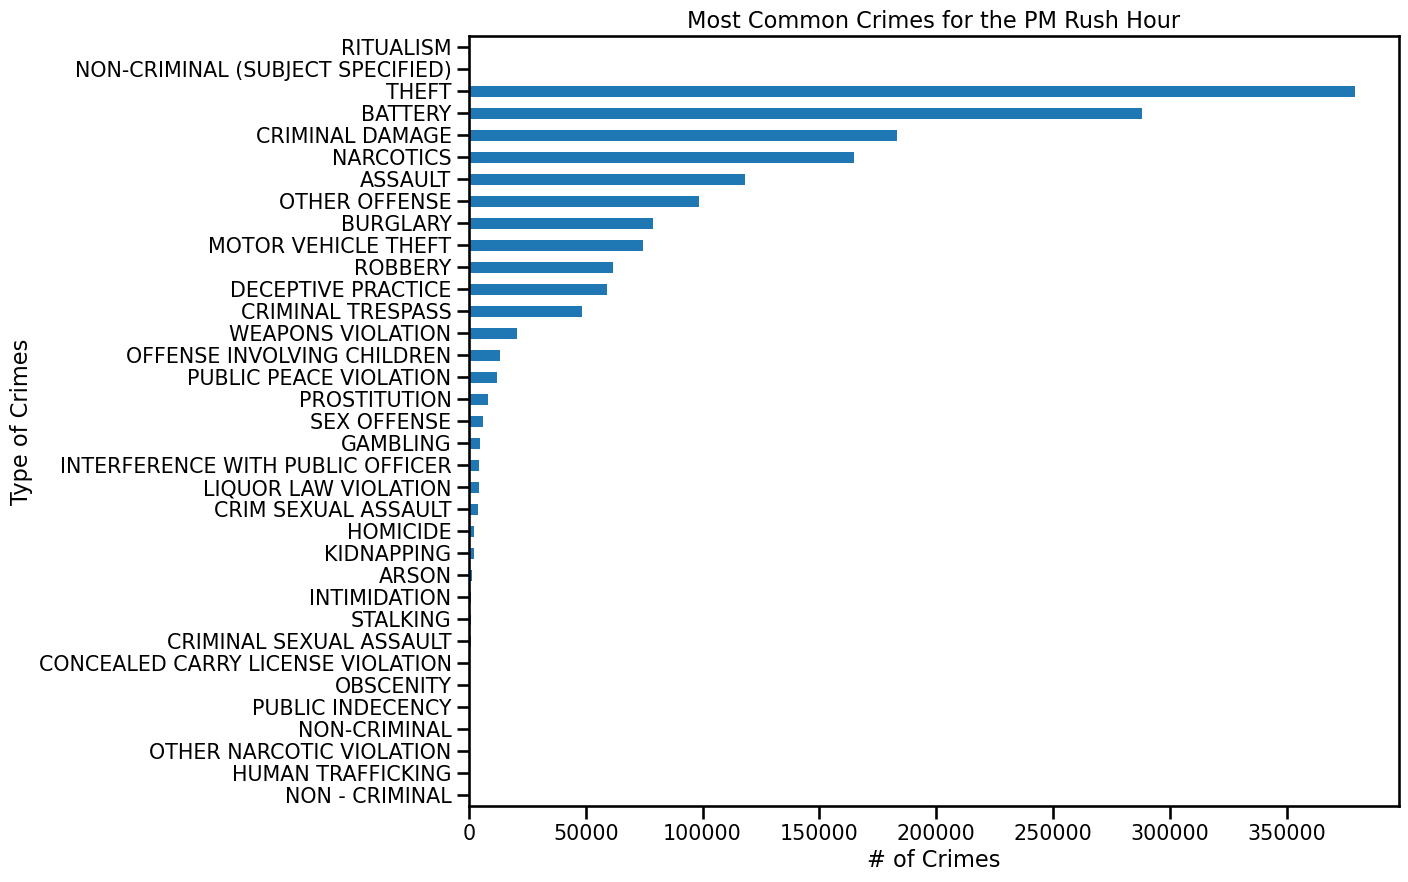

In [37]:
ax = pm_rush.sort_values().plot(kind='barh',figsize=(12,10))
ax.set(title='Most Common Crimes for the PM Rush Hour',xlabel='# of Crimes',ylabel='Type of Crimes');

### `The Top 5 most common crimes in the PM Rush are:`
* Theft
* Battery
* Criminal Damage
* Narcotics
* Assault`

### `Are Motor Vehicle Thefts more common during AM rush hour or PM Rush Hour?`

In [22]:
am_rush.loc['MOTOR VEHICLE THEFT']

54035

In [23]:
pm_rush.loc['MOTOR VEHICLE THEFT']

74678.0

### Looks like Motor Vehicle Theft is more common in the PM than the AM. However it would be intersting if morning is considered dusk or 12am or is morning considered more when the sun come up, and what are evenings is it when the sun sets or when people go to bed.

## <u>Topic 4) Comparing Months:
* `Answer the questions:` What months have the most crime? What months have the least?

In [27]:
df.index.month

Int64Index([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
            ...
            12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
           dtype='int64', name='Date', length=7713109)

In [28]:
# to visually see what these look like
df.head(2)

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude,HourOfDay
Date,,,,,,,,,,,,
2001-01-01 01:00:00,1326041,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185,1
2001-01-01 13:00:00,1319931,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841,13


In [29]:
# added month as column
# made sepearate copy of df 
Q3 = df.copy()
Q3['Month'] = df.index.month
Q3.head()

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude,HourOfDay,Month
Date,,,,,,,,,,,,,
2001-01-01 01:00:00,1326041,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185,1,1
2001-01-01 13:00:00,1319931,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841,13,1
2001-01-01 13:00:00,1324743,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970,13,1
2001-01-01 01:00:00,1310717,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032,1,1
2001-01-01 01:00:00,1318099,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020,1,1


<Axes: xlabel='Month'>

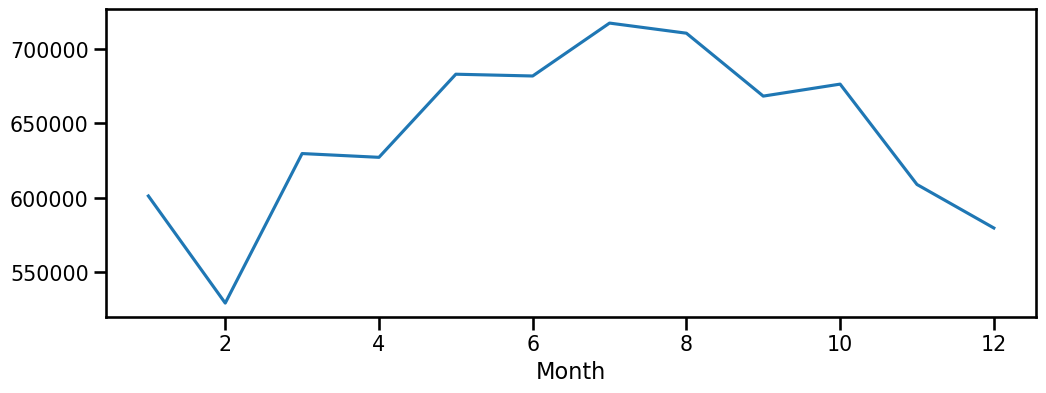

In [30]:
Q3.groupby('Month').size().plot()

- ### `July and August have the most. Jan, Feb, and dec have the least crimes.`

In [31]:
# need to use [] when we are grouping by on multiple columns 
Q3b = Q3.groupby(['Primary Type', 'Month']).size()
Q3b

Primary Type       Month
ARSON              1         917
                   2         807
                   3        1111
                   4        1097
                   5        1230
                            ... 
WEAPONS VIOLATION  8        9887
                   9        9435
                   10       9190
                   11       7952
                   12       7401
Length: 415, dtype: int64

* Answer the questions: Are there any individual crimes that do not follow this patter? If so, which crimes?

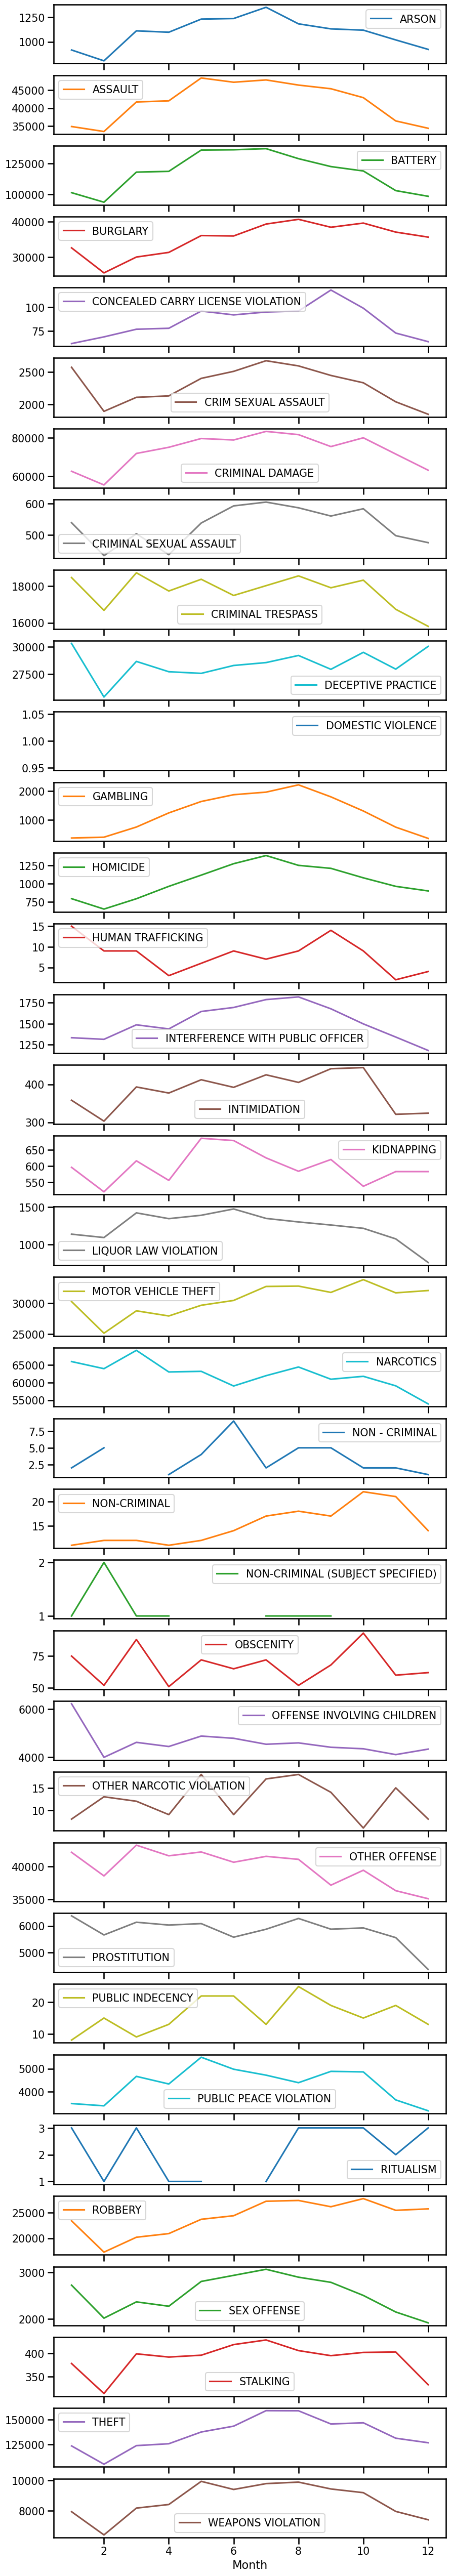

In [32]:
Q3b.unstack().T.plot(subplots = True, figsize = (10,65));

- ### `Yes there are for the following Crimes (Deceptive Practice, Human Trafficking, Narcotics, Non-Criminal, Obscenity, Offense Involving children, Prostitution, Robbery)`

## <u>`Feature Engineering Holidays for Topic 5`

In [ ]:
# Create an instance of the US country holidays.
us_holidays = country_holidays('US')
us_holidays

In [ ]:
# Testing first date
print(all_days[0])
us_holidays.get(all_days[0])

In [ ]:
# Getting us holidays for all dates
holiday_list = [us_holidays.get(day) for day in all_days]

In [ ]:
# For a specific subdivisions (e.g. state or province):
il_holidays = country_holidays('US', subdiv='IL')
il_holidays

In [ ]:
# Saving both holiday types as columns
df["US Holiday"] = [us_holidays.get(day) for day in df['Date']]
df['IL Holiday'] = [il_holidays.get(day) for day in df['Date']]
df.head()

In [ ]:
# US Holidays
df['US Holiday'].value_counts()

In [ ]:
# Illinois Holidays
df['IL Holiday'].value_counts()

In [ ]:
# Saving a binary is holiday feature
df['Is_Holiday'] = df['US Holiday'].notna()
df['Is_Holiday'].value_counts()

## <u>Topic 5) Comparing Months:</u>

* `Answer the questions:` What are the top 3 holidays with the largest number of crimes?

In [ ]:
# Looking at US Holidays
df_crime['US Holiday'].value_counts()

In [ ]:
# Looking at IL Holidays
df_crime['IL Holiday'].value_counts

`Top 3 Holiday crimes are` 

* `Answer the questions:` For each of the top 3 Holidays with the the most crime, what are the top 5 most common crimes of that holiday?

In [ ]:
df_crime.groupby('US Holiday')['Primary Type'].value_counts()

In [ ]:
df_crime.groupby('IL Holiday')[Primary Type].value_counts()

In [ ]:
# Plot New Year's Day crimes counts by types
ax = holiday.loc["New Year's Day"].plot(kind='bar')
ax.set(title="New Years Day Crimes", ylabel='# of Crimes');

## <u>Topic 6) What cycles (seasonality) can you find in this data?
* **Make sure to select the data of interest and that it is resampled to the frequency you want.** `(See the "Suggested data to check for seasons" list at the bottom of topic for suggestions).`
* **Use statmodels.tsa.seasonal.seasonal_decompose() the time series.**
    *  `Note:` seasonal_decompose cannot read data resampled as minutes or smaller, and ifyou try seconds, you will crash you computer. Keep your resampling at hours or more.
* **Show and describe each cycle you can find.**
    * ***(Hint: If your seasonal results are too dense to read, try zooming in to look at just one year or one month and try different levels of resampling).***
    * `Answer the questions:` How long is a cycle?
    * `Answer the questions:` What is the magnitude of the cycle? ***(Compare min and max)***
* <u>Suggested data to check for seasons:</u>
    * Total Crime `(Daily)`
    * Total Crime `(Weekly)`
    * Total Crime `(Monthly)`
    * Select a Primary Type of interest to you `(Daily)`
    * Select a Primary Type of interest to you `(Weekly)`
    * Select a Primary Type of interest to you `(Monthly)`